## CASA0006 Assignment

## Title: Predict traffic accident severity during the night period in London based on machine learning

### 1. Introduction

Poor visibility conditions increase the likelihood of severe traffic accidents, posing an endangering human life and property safety. To reduce casualties and enhance the effectiveness of accident management, it is essential to predict the severity of accidents accurately, allowing limited police and first aid resources to be deployed timely. This research seeks to establish highly accurate supervised machine learning models to predict the severity of traffic accidents during night-time in London. Utilizing traffic accident data from 2019 to 2022, the study intends to support police and hospital emergency departments in preparing for and responding to accidents of varying severity.

#### 1.1 Preparation for analysis

The analysis in this article is all based on python, thus, the list of all packages needed shows below

In [1]:
## Import packages

#packages for dataframe processing and plot the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# for transform the format of date in the dataframe later
from datetime import datetime

# for cross validation spliting the training and test data sets
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV

#for decision tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# for random forest (machine learning method 1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# for evaluating the importance of different features
import rfpimp

# check the library version before we start
print("sklearn version:{}".format(sklearn.__version__))
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

sklearn version:1.1.1


### 2. Literature review

Traffic accidents cause serious safety issue and severe damage to private and social property (Silva and Saraee, 2019). Traffic accidents are not completely random, which can be predict based on some aspects of factors with relatively high accuracy (Antonio, 2019). There are many studies on traffic accidents.

Some scholars are committed to researching the factors that have significant impacts on the severity of traffic accident. Sapsirisavat and Mahicul (2021) employed logistic regression to reveal that driving at night significantly increases the risk of serious health problems caused by traffic accidents in Thailand. Similarly, Liu et al. (2019) used a binomial logistic model to identify important factors that influence the severity of traffic accidents at night in China, including driver characteristics, light conditions, and road situations. Rain-related factors and human reaction time were also found to affect the occurrence of traffic accidents (Silva and Saraee, 2019). However, the factors influencing traffic accidents may differ across regions and cities and need to be analyzed accordingly (Liu et al., 2019).

In addition to identifying significant factors, scholars have also focused on improving prediction methods to enhance the accuracy of traffic accident severity and risk prediction. For instance, Al-Mistarehi et al. (2022) demonstrated that random forests are excellent machine learning methods for predicting traffic accident severity, and they combined high-resolution remote sensing images to analyze spatial distribution characteristics. Ren et al. (2018) developed a TARPML model to predict high-risk traffic accident areas in Beijing based on weather, air quality, traffic flows, and other factors. However, it is still hard for the police and the Emergency Center to allocate resources more accurately and efficiently according to the predicted demands.
Few scholars have distinguished between the prediction of traffic accidents during the day and at night, even though low illumination conditions increase the frequency and severity of accidents that occur during the night-time period (Haworth and Rechnitzer, 1993; Liu et al., 2019). Overall, the importance of identifying significant factors and improving prediction methods for traffic accidents cannot be ignored. It also emphasizes the need to distinguish between accidents that occur during the day and at night, as different factors may influence the severity and occurrence of accidents.

### 3. Research question

1. Which machine learning method has relatively higher accuracy for predicting the traffic accident severity in London in the night-time period, random forest, or decision tree?
2. What are the important factors affecting the prediction accuracy of traffic accident severity in London?



### 4. Presentation of data

Recent traffic accident data from 2019 to 2022 September is collected from Transport For London (TFL), which is the official website of a government agency takes account of different transport networks in London (Transport for London, n.d.) The dataset includes the information of each traffic accidents occurred in London, road conditions, and relevant environment information that considered in this assignment. Besides that, hourly updated air quality data is collected from UK AIR, which is an official website of the Department for Environment Food & Rural Affairs and includes data on PM 2.5 particulate matter, which is used in this research.

In [2]:
## Read in the road safety data:
acc2022 = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/accidents_2022.csv")
acc2021 = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/accidents_2021.csv", skiprows = 1)
acc2020 = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/accidents_2020.csv")
acc2019 = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/accidents_2019.csv")
air_quality = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/PM2.5_2019-2022.csv", nrows = 32856)

/tmp/ipykernel_6033/3733628186.py:6: DtypeWarning: Columns (2,6,10,12,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  air_quality = pd.read_csv("https://raw.githubusercontent.com/luzhao2000/CASA0006/main/PM2.5_2019-2022.csv", nrows = 32856)


In [3]:
# Deal with the "No Data" values in the air_quality data set:
air_quality = air_quality.replace('No data', np.nan, regex=True)

# Calculate mean PM2.5 hourly without consider the nan value
air_quality.iloc[:,2:] = air_quality.iloc[:,2:].astype(float)
air_quality['mean_PM2.5'] = 0.0
for i in range(len(air_quality)):
    air_quality.loc[i, 'mean_PM2.5'] = air_quality.iloc[i, 2:18].mean()

# Convert "Date" field into datetime-type data
air_quality['Date'] = pd.to_datetime(air_quality['Date'], format="%Y/%m/%d")
# convert "Time" field into int-type data
air_quality['hour'] = air_quality['Time'].str.split(":",expand = True)[0].astype(int)

# uniform the "hour" field with that in the accidents data set later:
for i in range(len(air_quality)):
    if air_quality.loc[i,'hour'] == 24:
        air_quality.loc[i,'hour'] = 0

# select useful columns:
air_quality = air_quality.iloc[:,[0,19,18]]
air_quality.info()
# air quality data set after pre-processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32856 entries, 0 to 32855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        32856 non-null  datetime64[ns]
 1   hour        32856 non-null  int64         
 2   mean_PM2.5  32856 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 770.2 KB


In [4]:
##Pre-processing accidents data:
# drop useless columns:
accidents2022 = acc2022.drop(['_Collision Id','Borough Name','_Vehicle Count','Highway Authority','Second Road Class','Collision Location', 'Second Road Number',
                      'Place Collision Reported','First Road Number','Special Conditions at Site','Carriageway Hazards','Junction Control'],axis = 1, inplace = False)
accidents2021 = acc2021.drop(['_Collision Id','Borough Name','_Vehicle Count','Highway Authority','Second Road Class','Collision Location', 'Second Road Number',
                      'Place Collision Reported','First Road Number','Special Conditions at Site','Carriageway Hazards','Junction Control'],axis = 1, inplace = False)
accidents2020 = acc2020.drop(['Accident Ref','Borough','Location','Highway','Road No. 1','Road Class 2', 'Road No 2','Special Conditions','C/W Hazard',
                              'ADATES_FULL','APOLICER_DECODED','Junction Control','No. of Vehicles in Acc.'], axis = 1)
accidents2019 = acc2019.drop(['Accident Ref','Borough','Location','Highway','Road No. 1','Road Class 2', 'Road No 2','Special Conditions','C/W Hazard',
                              'ADATES_FULL','APOLICER_DECODED','Junction Control','No. of Vehicles in Acc.'], axis = 1)

# rename columns:
accidents2022 = accidents2022.rename(columns={'Borough Number': 'borough_num','Easting':'east_coor','Northing':'north_coor','_Collision Severity':'severity',
                                              '_Casualty Count':'casualty_count','_Collision Date':'collision_date',
                                              'Day Name':'day','Time':'time','First Road Class':'first_road_class','Road Type':'road_type',
                                              'Speed Limit':'speed_limit','Junction Detail':'junction','Road Surface Condition':'road_surface',
                                              'Pedestrian Crossing Facilities':'pedestrian_crossing','Light Conditions':'light_conditions','Weather Details':'weather'})
accidents2021 = accidents2021.rename(columns={'Borough Number': 'borough_num','Easting':'east_coor','Northing':'north_coor','_Collision Severity':'severity',
                                              '_Casualty Count':'casualty_count','_Collision Date':'collision_date',
                                              'Day Name':'day','Time':'time','First Road Class':'first_road_class','Road Type':'road_type',
                                              'Speed Limit':'speed_limit','Junction Detail':'junction','Pedestrian Crossing Facilities':'pedestrian_crossing',
                                              'Light Conditions':'light_conditions','Weather Details':'weather','Road Surface Condition':'road_surface'})
accidents2020 = accidents2020.rename(columns={'Boro': 'borough_num','Easting':'east_coor','Northing':'north_coor','Accident Severity':'severity',
                                              'No. of Casualties in Acc.':'casualty_count','Accident Date':'collision_date',
                                              'Day':'day','Time':'time','Road Class 1':'first_road_class','Road Type':'road_type',
                                              'Speed Limit':'speed_limit','Junction Detail':'junction','Ped. Crossing Decoded':'pedestrian_crossing',
                                              'Light Condtions (Banded)':'light_conditions','Weather':'weather','Road Surface':'road_surface'})
accidents2019 = accidents2019.rename(columns={'Boro': 'borough_num','Easting':'east_coor','Northing':'north_coor','Accident Severity':'severity',
                                              'No. of Casualties in Acc.':'casualty_count','Accident Date':'collision_date',
                                              'Day':'day','Time':'time','Road Class 1':'first_road_class','Road Type':'road_type','Speed Limit':'speed_limit',
                                              'Junction Detail':'junction','Ped. Crossing Decoded':'pedestrian_crossing','Light Condtions (Banded)':'light_conditions',
                                              'Weather':'weather','Road Surface':'road_surface'})
# join data sets together:
accidents = pd.concat([accidents2022,accidents2021,accidents2020,accidents2019],ignore_index = True, axis = 0)

In [5]:
# Uniform the values or categories in each column:
c = ['severity','road_type','junction','pedestrian_crossing','weather','road_surface']
for i in c:
    accidents[i] = accidents[i].str.replace('\d', '')
    accidents[i] = accidents[i].str.replace(" ", "")
    accidents[i] = accidents[i].str.lower()
    accidents[i] = accidents[i].str.replace('(', '')
    accidents[i] = accidents[i].str.replace(')', '')

accidents['first_road_class'] = accidents['first_road_class'].str.replace('UNCLASSIFIED', 'Unclassified')

accidents['light_conditions'] = accidents['light_conditions'].str.replace('2 DAYLIGHT', 'Daylight')
accidents['light_conditions'] = accidents['light_conditions'].str.replace("1 DARK", "Dark")

accidents['junction'] = accidents['junction'].str.replace('croassroads','crossroads')

/tmp/ipykernel_6033/7586736.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  accidents[i] = accidents[i].str.replace('\d', '')
/tmp/ipykernel_6033/7586736.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  accidents[i] = accidents[i].str.replace('(', '')
/tmp/ipykernel_6033/7586736.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  accidents[i] = accidents[i].str.replace(')', '')


In [6]:
# Compute new columns (month, hour, and days since 2019-01-01) and change data types
accidents['month'] = accidents['collision_date'].str.split('/', expand=True)[1].astype(int)
accidents['hour'] = accidents['time'].str.split(':', expand = True)[0].astype(int)
accidents['collision_date'] = accidents['collision_date'].str.split(' ', expand=True)[0]
accidents['date'] = pd.to_datetime(accidents['collision_date'], format="%d/%m/%Y")
accidents['days_since_2019'] = 0
first_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
for i in range(len(accidents)):
    accidents.loc[i,'days_since_2019'] = (accidents.loc[i,'date'] - first_date)
accidents['days_since_2019'] = accidents['days_since_2019'].astype(str)
accidents['days_since_2019'] = accidents['days_since_2019'].str.split(' ', expand = True)[0].astype(int)

# merge air_quality and accidents together:
accidents = accidents.merge(air_quality, how = 'inner', left_on = ['date', 'hour'], right_on = ['Date', 'hour'])
accidents.head()

,borough_num,east_coor,north_coor,severity,casualty_count,collision_date,day,time,first_road_class,road_type,...,pedestrian_crossing,light_conditions,weather,road_surface,month,hour,date,days_since_2019,Date,mean_PM2.5
0,0,533185,181433,serious,2,15/02/2022,Tuesday,06:55,A,dualcwy,...,pednphaseatats,Daylight,fine,road-dry,2,6,2022-02-15,1141,2022-02-15,4.9556
1,14,545374,185785,slight,1,15/02/2022,Tuesday,06:30,Unclassified,singlecwy,...,noxingfacilityinm,Dark - Street Lighting Unknown,other,road-wet,2,6,2022-02-15,1141,2022-02-15,4.9556
2,0,533192,181443,slight,1,25/02/2022,Friday,17:00,A,dualcwy,...,pednphaseatats,Daylight,fine,road-dry,2,17,2022-02-25,1151,2022-02-25,7.9500
3,27,514877,180162,slight,1,25/02/2022,Friday,17:14,A,singlecwy,...,noxingfacilityinm,Daylight,fine,road-dry,2,17,2022-02-25,1151,2022-02-25,7.9500
4,11,522684,180553,slight,1,25/02/2022,Friday,17:10,Unclassified,dualcwy,...,noxingfacilityinm,Daylight,fine,road-dry,2,17,2022-02-25,1151,2022-02-25,7.9500


In [7]:
# Change 'severity' field into integer categorical field
accidents['severity_level'] = 0
for i in range(len(accidents)):
    if accidents.loc[i,'severity'] == "slight":
        accidents.loc[i,'severity_level'] = 1
    elif accidents.loc[i,'severity'] == "serious":
        accidents.loc[i,'severity_level'] = 2
    else:
        accidents.loc[i,'severity_level'] = 3
accidents['severity_level'] = accidents['severity_level'].astype(int)

# drop less meaningful variables
accidents = accidents.drop(['severity','collision_date','time','date','Date'], axis = 1)

# check the structure of dataframe and the null values in the data set
accidents.info()
print(accidents.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87143 entries, 0 to 87142
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough_num          87143 non-null  int64  
 1   east_coor            87143 non-null  int64  
 2   north_coor           87143 non-null  int64  
 3   casualty_count       87143 non-null  int64  
 4   day                  87143 non-null  object 
 5   first_road_class     87143 non-null  object 
 6   road_type            87143 non-null  object 
 7   speed_limit          87143 non-null  int64  
 8   junction             87143 non-null  object 
 9   pedestrian_crossing  87143 non-null  object 
 10  light_conditions     87143 non-null  object 
 11  weather              87143 non-null  object 
 12  road_surface         87143 non-null  object 
 13  month                87143 non-null  int64  
 14  hour                 87143 non-null  int64  
 15  days_since_2019      87143 non-null 

In [8]:
# transfor data types for predicting classification
#day:
for i in range(len(accidents)):
    if accidents.loc[i,'day'] == 'Monday':
        accidents.loc[i,'day'] = 1
    elif accidents.loc[i,'day'] == 'Tuesday':
        accidents.loc[i,'day'] = 2
    elif accidents.loc[i,'day'] == 'Wednesday':
        accidents.loc[i,'day'] = 3
    elif accidents.loc[i,'day'] == 'Thursday':
        accidents.loc[i,'day'] = 4
    elif accidents.loc[i,'day'] == 'Friday':
        accidents.loc[i,'day'] = 5
    elif accidents.loc[i,'day'] == 'Saturday':
        accidents.loc[i,'day'] = 6
    else:
        accidents.loc[i,'day'] = 7
accidents['day'] = accidents['day'].astype(int)
#first road class:
for i in range(len(accidents)):
    if accidents.loc[i,'first_road_class'] == 'A':
        accidents.loc[i,'first_road_class'] = 1
    elif accidents.loc[i,'first_road_class'] == 'B':
        accidents.loc[i,'first_road_class'] = 2
    elif accidents.loc[i,'first_road_class'] == 'C':
        accidents.loc[i,'first_road_class'] = 3
    elif accidents.loc[i,'first_road_class'] == 'M':
        accidents.loc[i,'first_road_class'] = 4
    elif accidents.loc[i,'first_road_class'] == 'Unclassified':
        accidents.loc[i,'first_road_class'] = 7
    else:
        accidents.loc[i,'first_road_class'] = accidents.loc[i,'first_road_class']
accidents['first_road_class'] = accidents['first_road_class'].astype(int)

#road type:
for i in range(len(accidents)):
    if accidents.loc[i,'road_type'] == 'singlecwy':
        accidents.loc[i,'road_type'] = 1
    elif accidents.loc[i,'road_type'] == 'dualcwy':
        accidents.loc[i,'road_type'] = 2
    elif accidents.loc[i,'road_type'] == 'one-wayst':
        accidents.loc[i,'road_type'] = 3
    elif accidents.loc[i,'road_type'] == 'roundabout':
        accidents.loc[i,'road_type'] = 4
    elif accidents.loc[i,'road_type'] == 'sliprd':
        accidents.loc[i,'road_type'] = 5
    else:
        accidents.loc[i,'road_type'] = 6
accidents['road_type'] = accidents['road_type'].astype(int)

#junction:
for i in range(len(accidents)):
    if accidents.loc[i,'junction'] == 't/stagjun':
        accidents.loc[i,'junction'] = 1
    elif accidents.loc[i,'junction'] == 'nojuninm':
        accidents.loc[i,'junction'] = 2
    elif accidents.loc[i,'junction'] == 'otherjun':
        accidents.loc[i,'junction'] = 3
    elif accidents.loc[i,'junction'] == 'crossroads':
        accidents.loc[i,'junction'] = 4
    elif accidents.loc[i,'junction'] == 'roundabout':
        accidents.loc[i,'junction'] = 5
    elif accidents.loc[i,'junction'] == 'multijun':
        accidents.loc[i,'junction'] = 6
    elif accidents.loc[i,'junction'] == 'sliproad':
        accidents.loc[i,'junction'] = 7
    elif accidents.loc[i,'junction'] == 'privdrive':
        accidents.loc[i,'junction'] = 8
    elif accidents.loc[i,'junction'] == 'mini':
        accidents.loc[i,'junction'] = 9
    else:
        accidents.loc[i,'junction'] = 10
accidents['junction'] = accidents['junction'].astype(int)

#crossing_facilities:
for i in range(len(accidents)):
    if accidents.loc[i,'pedestrian_crossing'] == 'noxingfacilityinm':
        accidents.loc[i,'pedestrian_crossing'] = 1
    elif accidents.loc[i,'pedestrian_crossing'] == 'pednphaseatats':
        accidents.loc[i,'pedestrian_crossing'] = 2
    elif accidents.loc[i,'pedestrian_crossing'] == 'zebra':
        accidents.loc[i,'pedestrian_crossing'] = 3
    elif accidents.loc[i,'pedestrian_crossing'] == 'pelicanorsimilar':
        accidents.loc[i,'pedestrian_crossing'] = 4
    elif accidents.loc[i,'pedestrian_crossing'] == 'centralrefuge':
        accidents.loc[i,'pedestrian_crossing'] = 5
    elif accidents.loc[i,'pedestrian_crossing'] == 'footbridgeorsubway':
        accidents.loc[i,'pedestrian_crossing'] = 6
    else:
        accidents.loc[i,'pedestrian_crossing'] = 7
accidents['pedestrian_crossing'] = accidents['pedestrian_crossing'].astype(int)

#light_conditions
for i in range(len(accidents)):
    if accidents.loc[i,'light_conditions'] == 'Daylight':
        accidents.loc[i,'light_conditions'] = 1
    elif accidents.loc[i,'light_conditions'] == 'Dark - Street Lights Present & Lit':
        accidents.loc[i,'light_conditions'] = 2
    elif accidents.loc[i,'light_conditions'] == 'Dark - Street Lights Present Unlit':
        accidents.loc[i,'light_conditions'] = 3
    elif accidents.loc[i,'light_conditions'] == 'Dark - No Street Lighting':
        accidents.loc[i,'light_conditions'] = 4
    elif accidents.loc[i,'light_conditions'] == 'Dark':
        accidents.loc[i,'light_conditions'] = 5
    else:
        accidents.loc[i,'light_conditions'] = 6
accidents['light_conditions'] = accidents['light_conditions'].astype(int)

#weather
for i in range(len(accidents)):
    if accidents.loc[i,'weather'] == 'fine':
        accidents.loc[i,'weather'] = 1
    elif accidents.loc[i,'weather'] == 'raining':
        accidents.loc[i,'weather'] = 2
    elif accidents.loc[i,'weather'] == 'other':
        accidents.loc[i,'weather'] = 3
    elif accidents.loc[i,'weather'] == 'fine/highwinds':
        accidents.loc[i,'weather'] = 4
    elif accidents.loc[i,'weather'] == 'raining/highwinds':
        accidents.loc[i,'weather'] = 5
    elif accidents.loc[i,'weather'] == 'snowing':
        accidents.loc[i,'weather'] = 6
    elif accidents.loc[i,'weather'] == 'fog/mist':
        accidents.loc[i,'weather'] = 7
    elif accidents.loc[i,'weather'] == 'snowing/highwinds':
        accidents.loc[i,'weather'] = 8
    else:
        accidents.loc[i,'weather'] = 9
accidents['weather'] = accidents['weather'].astype(int)

#road_surface:
for i in range(len(accidents)):
    if accidents.loc[i,'road_surface'] == 'road-dry':
        accidents.loc[i,'road_surface'] = 1
    elif accidents.loc[i,'road_surface'] == 'road-wet':
        accidents.loc[i,'road_surface'] = 2
    elif accidents.loc[i,'road_surface'] == 'road-frost/ice':
        accidents.loc[i,'road_surface'] = 3
    elif accidents.loc[i,'road_surface'] == 'road-snow':
        accidents.loc[i,'road_surface'] = 4
    elif accidents.loc[i,'road_surface'] == 'road-flood':
        accidents.loc[i,'road_surface'] = 5
    else:
        accidents.loc[i,'road_surface'] = 6
accidents['road_surface'] = accidents['road_surface'].astype(int)

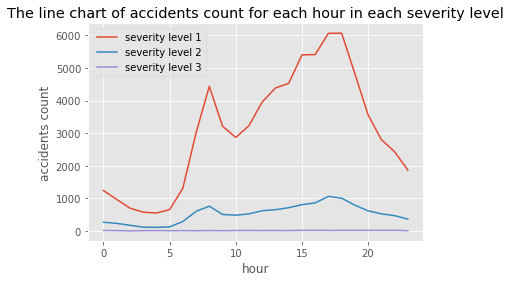

In [9]:
# create a line chart comparing the number of traffic accident with 
# different severity happened in each hour
df1 = accidents[accidents['severity_level'] == 1]['hour'].value_counts().to_frame().sort_index()
df2 = accidents[accidents['severity_level'] == 2]['hour'].value_counts().to_frame().sort_index()
df3 = accidents[accidents['severity_level'] == 3]['hour'].value_counts().to_frame().sort_index()

# Create the plot
plt.plot(df1.index,df1['hour'],label='severity level 1')
plt.plot(df2.index,df2['hour'],label='severity level 2')
plt.plot(df3.index,df3['hour'],label='severity level 3')

# Add labels and title
plt.xlabel('hour')
plt.ylabel('accidents count')
plt.title('The line chart of accidents count for each hour in each severity level')

# Add legend
plt.legend()

# Show the plot
plt.show()

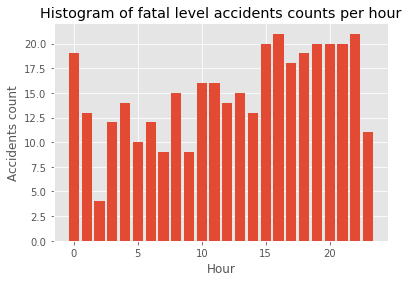

In [10]:
# histogram for representing numbers of severity accidents happened in each hour:
fatal_accidents = accidents[accidents['severity_level'] == 3]
# group the data by period
grouped_accidents = fatal_accidents.groupby('hour').size()
grouped_accidents = grouped_accidents.to_frame().reset_index()

# Plot the histogram
plt.bar(grouped_accidents['hour'],grouped_accidents[0])

# Add axis labels and title
plt.xlabel('Hour')
plt.ylabel('Accidents count')
plt.title('Histogram of fatal level accidents counts per hour')

# Display the plot
plt.show()

According to the above line chart and the histogram, there are many traffic accidents in London, especially during the morning rush hour and at night. Moreover, although most traffic accidents are mild, there are significantly more fatal accidents at night than during the day. This also reflects the importance of studying night traffic accidents.

In [11]:
# select the data occurs during 16-23 and 0-7:
acc_night = accidents[((accidents.hour >= 16 )&(accidents.hour <= 23 )) | ((accidents.hour >= 0 ) & (accidents.hour <= 7 )) ]
acc_night.reset_index(drop = True,inplace = True)
acc_night.head()
# all data after pre-processing

,borough_num,east_coor,north_coor,casualty_count,day,first_road_class,road_type,speed_limit,junction,pedestrian_crossing,light_conditions,weather,road_surface,month,hour,days_since_2019,mean_PM2.5,severity_level
0,0,533185,181433,2,2,1,2,20,4,2,1,1,1,2,6,1141,4.9556,2
1,14,545374,185785,1,2,7,1,30,1,1,6,3,2,2,6,1141,4.9556,1
2,0,533192,181443,1,5,1,2,20,4,2,1,1,1,2,17,1151,7.9500,1
3,27,514877,180162,1,5,1,1,20,2,1,1,1,1,2,17,1151,7.9500,1
4,11,522684,180553,1,5,7,2,20,2,1,1,1,1,2,17,1151,7.9500,1


In [12]:
acc_night.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49927 entries, 0 to 49926
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough_num          49927 non-null  int64  
 1   east_coor            49927 non-null  int64  
 2   north_coor           49927 non-null  int64  
 3   casualty_count       49927 non-null  int64  
 4   day                  49927 non-null  int64  
 5   first_road_class     49927 non-null  int64  
 6   road_type            49927 non-null  int64  
 7   speed_limit          49927 non-null  int64  
 8   junction             49927 non-null  int64  
 9   pedestrian_crossing  49927 non-null  int64  
 10  light_conditions     49927 non-null  int64  
 11  weather              49927 non-null  int64  
 12  road_surface         49927 non-null  int64  
 13  month                49927 non-null  int64  
 14  hour                 49927 non-null  int64  
 15  days_since_2019      49927 non-null 

In [13]:
acc_night.describe()

,borough_num,east_coor,north_coor,casualty_count,day,first_road_class,road_type,speed_limit,junction,pedestrian_crossing,light_conditions,weather,road_surface,month,hour,days_since_2019,mean_PM2.5,severity_level
count,"49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000","49,927.0000"
mean,15.2205,"530,667.5239","180,717.1179",1.1762,3.9767,2.4629,1.9556,27.4303,3.2240,2.5225,2.4649,1.6914,1.4409,6.4764,15.4991,682.8773,9.7040,1.1629
std,9.8449,"9,644.3557","7,432.0921",0.5465,1.9225,2.2257,1.5233,7.8603,2.6593,2.0548,1.7778,1.7961,1.0568,3.3149,6.4042,403.1014,6.3539,0.3822
min,0.0000,"503,607.0000","156,929.0000",1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.4600,1.0000
25%,7.0000,"525,094.0000","176,003.5000",1.0000,2.0000,1.0000,1.0000,20.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0000,16.0000,315.0000,5.9692,1.0000
50%,14.0000,"531,128.0000","181,165.0000",1.0000,4.0000,1.0000,1.0000,30.0000,2.0000,2.0000,2.0000,1.0000,1.0000,7.0000,18.0000,679.0000,7.8300,1.0000
75%,25.0000,"536,307.0000","185,713.0000",1.0000,6.0000,3.0000,2.0000,30.0000,4.0000,3.0000,5.0000,1.0000,2.0000,9.0000,20.0000,"1,034.0000",11.0652,1.0000
max,32.0000,"560,066.0000","200,902.0000",11.0000,7.0000,7.0000,6.0000,300.0000,10.0000,7.0000,6.0000,9.0000,6.0000,12.0000,23.0000,"1,368.0000",129.8200,3.0000


| Field name | Units | Description |
| :-: | :-: | :- |
| borongh_num | None | Distinct number for each borough in London, represent the general locations of accidents |
| east_coor | Meter | Easting coordinate based on Ordnance Survey National Grid (OSGB), describe the specific locations of accidents |
| north_coor | Meter | Northing coordinate based on OSGB, describe the specific locations of accidents |
| casualty_count | None | Number of casualties after the traffic accident |
| day | None | The day in the week (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, and Sunday) |
| first_road_class | None | Types of first road classified based on the criteria in the United Kingdom, e.g. ‘A’, ‘B’. |
| road_type | None | Road types, e.g. single carriageway, dual carriageway |
| speed_limit | miles/ hour | The speed limit of the road that the traffic accidents occurred.|
| junction | None | Type of junctions nearby the traffic accidents, e.g. non junction, cross road.|
| pedestrian_crossing | None | Categorical numeric feature represents the type of pedestrian crossing facilities close to the traffic accidents, e.g. 3 – ‘zebra’, 5 – ‘central refuge’.|
| light_conditions | None |Degree of the light conditions when the traffic accident happened, e.g. 1 – ‘day light’, 4 – ‘dark – no street lights’. |
| weather | None | Categorical numeric feature reflects the weather conditions when the traffic accident occurred, e.g. 1 – ‘fine’, 2 – ‘raining’.|
| road_surface | None | Categorical numeric feature refers to the road surface conditions when the accidents happened, e.g. 1 – ‘road-dry’, 3 – ‘road-frost/ice’.|
| month | None | Month of the year represented by integers.|
| hour | None | Hour of the day, which is represented by integers.|
| days_since_2019 | days | Number of days since the first day of the research period (2019-01-01), which is considered as the date feature. |
| mean_PM2.5 | μg/m^3 | Average PM 2.5 particulate matter per hour in London| 
| severity_level | None | Categorical numeric feature represent different traffic accident severities based on the criteria in the UK (1 – ‘Slight’; 2 – ‘Serious’; 3 – ‘Fatal’).|

Table 1 Descriptive statistics of the data set after pre-processing.

After pre-processing and merging procedures, the dataset contains 49927 traffic accidents with corresponding boroughs, location coordinates, casualty counts, day of the week, first road classes, road types, speed limit of the road with accidents occurred in London from 2019 to September 2022 during the low illumination period from 16:00 to 7:00 the next morning. The dataset also includes information on nearby junction types, crosswalk facility types, lighting conditions, weather, road surface conditions, month, hour of the day, and the number of days since the first day of research 2019-01-01 as the feature ‘date’.

### 5. Methodology

Classification is the process of predicting categorical data based on constructed classifiers (Silva and Saraee, 2019). Since the dependent variable is traffic accident severity, which is a categorical variable, classification is more suitable for predicting the severity level than regression. In this study, supervised machine learning models with tuning hyperparameters based on cross validation were proposed, including CART and random forest, and evaluations are based on four metrics (overall accuracy, precision, recall, F1 score).

According to Haworth and Rechnitzer (1993) and taking into account the changes in daylight hours throughout the year in London, the low illumination period set in this study is from 4 p.m. to 7 a.m. in the following morning.

#### 5.1 Feature selection

Based on the above research questions, overview of the selected features (independent variables) with description which might influence the severities of traffic accidents in London are listed in the above Table 1. In addition, considering the concentration of PM 2.5 particles was added because Sager (2019) found through research that increase of 1ug/m^3 % of the concentration of PM 2.5 particles will increase the number of vehicles involved in traffic accidents by 0.3% to 0.6%.

#### 5.2 Supervised machine learning models with tuning hyperparameters

Cross-validation is a validation method that obtains the best machine learning model with necessary parameters by dividing the original dataset into training, development, and testing data under different folds. After obtaining the hyperparameters, the training data set would be used to train the final machine learning model and evaluate it based on the testing data set (Browne, 2000). Although it uses the training data effectively and prevents overfitting to some extent, it is time-consuming and computationally intensive (Abhishek, 2023). This study used 5-fold cross-validation to build machine learning models and obtain hyperparameters for CART and random forest models.

In [14]:
## Machine Learning

#Split the data into training and testing subsets 
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(acc_night.drop(['severity_level'], axis = 1), acc_night.severity_level,
                                                    random_state=random_state_split)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(37445, 17)
(37445,)
(12482, 17)
(12482,)
True
True


#### 5.2.1 CART

Classification and regression Tree (CART) is a type of decision tree (Muller and Möckel, 2008). Predefined stopping criteria are crucial in establishing CART models, including essential hyperparameters including max tree depth and minimal instances in a tree node

In [15]:
# a CART using default settings for getting the tree depth
cart_default = DecisionTreeClassifier(random_state=0)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

# Tuning hyperparameters of CART: get the values of max_depth and min_samples_split by using cross validation
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
dt = DecisionTreeClassifier(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_) 

#meaning of best score? how to interpret it?
# -> calculated by the average of score of all the cross-validation fold for a single combination of the parameters you specify in the tuned_params
# which can be used to choose the best pair of hyperparameters
# but dont need to know the actual meaning or how to calculater score here.

Tree depth: 49
The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 10}
The best score is: 
0.8359994658832954


In [16]:
# Train the final decision tree model:
dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

# Evaluate the prediction accuracy of CART based on precision, recall, and F1-score:
Y_pred = dt_final.predict(test_x)
dt_final.score(test_x, test_y)
acc_dt1 = round(dt_final.score(test_x, test_y),4)
sk_report = classification_report(
    digits=6,
    y_true=test_y, 
    y_pred=Y_pred)
print("Accuracy" , acc_dt1)
print(sk_report)
# corresponding confusion matrix:
pd.crosstab(test_y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.8347
              precision    recall  f1-score   support

           1   0.840116  0.992275  0.909878     10485
           2   0.153061  0.007716  0.014691      1944
           3   0.000000  0.000000  0.000000        53

    accuracy                       0.834722     12482
   macro avg   0.331059  0.333330  0.308190     12482
weighted avg   0.729544  0.834722  0.766594     12482



Predicted,1,2,All
Actual,,,
1,10404,81,10485
2,1929,15,1944
3,51,2,53
All,12384,98,12482


In [17]:
#importance of different features
imp = rfpimp.importances(dt_final, test_x, test_y)
print(imp)

                                                  Importance
Feature                                                     
borough_num                                           0.0030
road_type                                             0.0022
days_since_2019                                       0.0014
weather                                               0.0012
north_coor                                            0.0010
day                                                   0.0006
road_surface                                          0.0004
speed_limit                                           0.0002
month                                                 0.0002
casualty_count                                        0.0000
light_conditions                                      0.0000
mean_PM2.5                                           -0.0002
pedestrian_crossing                                  -0.0002
first_road_class                                     -0.0006
junction                

#### 5.2.2 Random Forest

Random forest is an ensemble learning based on the bagging technique (Liu and Wu, 2017). It can be considered as a classifier that integrates multiple decision trees and can be used to solve more complex problems, improve the model robustness, and enhance prediction accuracy (Liu and Wu, 2017).

In [18]:
# Tuning hyperparameters of Random Forest: get the values of max_depth and min_samples_split by using cross validation
param_grid = {
    'max_depth': [10,20,30,40,50],
    'min_samples_split': [2, 4, 6, 8]
}
# Create a based model
randomState_rf = 10000
random_f = RandomForestClassifier()

# Instantiate the grid search model
rf_grid_search = GridSearchCV(random_f, param_grid)
rf_grid_search.fit(train_x,train_y)
print(rf_grid_search.best_params_)
print(rf_grid_search.best_score_)

{'max_depth': 20, 'min_samples_split': 8}
0.8426759246895447


In [19]:
#Train the final Random Forest model
random_forest = RandomForestClassifier(max_depth=rf_grid_search.best_params_['max_depth'], min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                       random_state=randomState_rf)
random_forest.fit(train_x,train_y)

#Evaluate prediction accuracy of the random forest model based on precision, recall, and F1-score
Y_pred = random_forest.predict(test_x)
random_forest.score(test_x, test_y)
acc_random_forest1 = round(random_forest.score(test_x, test_y),4)
sk_report = classification_report(
    digits=6,
    y_true=test_y, 
    y_pred=Y_pred)
print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(test_y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 0.8396
              precision    recall  f1-score   support

           1   0.839945  0.999523  0.912812     10485
           2   0.000000  0.000000  0.000000      1944
           3   0.000000  0.000000  0.000000        53

    accuracy                       0.839609     12482
   macro avg   0.279982  0.333174  0.304271     12482
weighted avg   0.705562  0.839609  0.766771     12482



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,1,2,All
Actual,,,
1,10480,5,10485
2,1944,0,1944
3,53,0,53
All,12477,5,12482


Importance of features in the decision tree classification model

In [20]:
imp = rfpimp.importances(random_forest, test_x, test_y)
print(imp)

                                                  Importance
Feature                                                     
first_road_class                                      0.0004
road_type                                             0.0002
borough_num                                           0.0000
pedestrian_crossing                                   0.0000
days_since_2019                                       0.0000
hour                                                  0.0000
month                                                 0.0000
road_surface                                          0.0000
light_conditions                                      0.0000
junction                                              0.0000
east_coor                                             0.0000
speed_limit                                           0.0000
casualty_count                                        0.0000
weather                                              -0.0002
day                     

#### 5.3 Evaluation of prediction

Confusion matrix is an important metric for evaluating the performance of classification. Classification accuracy, precision, recall, and F1 score are four measures that reflect the accuracy of prediction from different perspectives based on the confusion matrix (Al-Mistarehi et al., 2022). Classification accuracy is the proportion of correctly predicted data (Al-Mistarehi et al., 2022). Recall represents the proportion of positive classes that are correctly classified (Al-Mistarehi et al., 2022). F1 score balances the importance of precision and recall, which is useful to compare the performance of different models when data imbalance is noticeable (Al-Mistarehi et al., 2022).

### 6. Results

The CART model achieved a high level of prediction accuracy (83.47%), which can accurately predict slight level traffic accidents with a 0.84 precision score, and the corresponding recall value is about 0.99, indicating rare misclassification of slight traffic accidents. However, the performance in predicting serious traffic accidents is poor, with the precision score is 0.15 and a low corresponding recall (about 0.008). The F1 score of slight level prediction is about 0.91 and that of serious is about 0.015. In this case, CART is unable to predict fatal level traffic accidents, which can also be seen in the confusion matrix below, fatal traffic accidents are predicted as mild (51) and severe (2). In addition, the most important features of CART were found to be the type of borough, road type, and date.

Random forest achieved a prediction accuracy of about 83.97%, outperforming CART. The precision of Slight accidents prediction is 0.8399 and the recall is about 0.9995 indicating the classification of most slight accidents into the correct category. However, the random forest model was failed to predict both serious and fatal level traffic accidents under this situation. Road types and first road class are two important factors affect the prediction accuracy of that random forest model.

### 7. Discussion

The CART model had a slightly higher precision for predicting slight level accidents compared to the random forest model, while the latter model got higher F1 score and performs better overall due to the imbalanced data. In contrast, CART performed much better in predicting serious-level accidents as random forest failed to predict any serious accident correctly. However, both models failed to predict fatal-level traffic accidents, indicating that more important features should be considered based on the basic situation in London when building models is necessary to improve the accuracy. In addition, the study also highlights the importance of the selected feature in predicting traffic accident severity. It can be found that no matter which model is established, the selected features in the study have low importance values, indicating that they may not be sufficient to accurately predict traffic accident severity in London at night.

Although the established models can predict traffic accident severity in London under low visibility accurately, there are still some limitations. First, the prediction accuracy for the severity of traffic accidents is limited. Since the number of traffic accidents in real life is significantly less than that of mild traffic accidents, it is necessary to increase the data set of the training model to train the model and improve the prediction accuracy to a certain extent. Secondly, the air quality index is only calculated based on the data of the limited air quality stations to obtain the average PM2.5 particle concentration hourly updated. This could result in errors in predicting the severity. Using meteorological satellite data could provide higher-resolution air quality data, which could help to enhance the accuracy.

### 8. Conclusion

In conclusion, machine learning can predict traffic accident severity in London during the night-time period accurately. The CART model has better performance in predicting mild and serious traffic accidents in London at night, while the random forest model was slightly better in predicting slight traffic accidents. However, neither model can predict fatal traffic accidents. The study highlights the importance of location, time, and road facilities in predicting traffic accident severity. Future work could focus on enhancing the accuracy of fatal traffic to help emergency services prepare in advance and potentially save more lives.

#### Word Counts: 2053

### References

Abhishek, S. (2023). ‘Cross Validation in Machine Learning’. GeeksforGeeks. Available at: https://www.geeksforgeeks.org/cross-validation-machine-learning/ (Accessed: 23 April 2023)

Air Information Resource. (n.d.). UK AIR. Available at: https://uk-air.defra.gov.uk/data/datawarehouse. (Accessed: 18 April, 2023)

Antonio, M. (2019). ‘Live Prediction of Traffic Accident Risks Using Machine Learning and Google Maps’. Towards Data Science. Available at: https://towardsdatascience.com/live-prediction-of-traffic-accident-risks-using-machine-learning-and-google-maps-d2eeffb9389e (Accessed: 17 April 2023).

Browne, M. (2000). ‘Cross-Validation Methods’. Journal of Mathematical Psychology, 44, 1, pp. 108–132.

Haworth, N. and G. Rechnitzer, (1993). ‘DESCRIPTION OF FATAL CRASHES INVOLVING VARIOUS CAUSAL VARIABLES’. in Proceedings of the student research workshop at ACL. Medicine. Available at: https://www.semanticscholar.org/paper/DESCRIPTION-OF-FATAL-CRASHES-INVOLVING-VARIOUS-Haworth-Rechnitzer/bb99eb0d51145b159ac9da298867b595ea911601 (Accessed: 23 April 2023).

Liu, J., J. Li, K. Wang, J. Zhao, H. Cong, and P. He, (2019). ‘Exploring factors affecting the severity of night-time vehicle accidents under low illumination conditions’. Advances in Mechanical Engineering, 11, 4, p. 168781401984094.

Liu, Y. and H. Wu, (2017). ‘Prediction of Road Traffic Congestion Based on Random Forest’. in 2017 10th International Symposium on Computational Intelligence and Design (ISCID), pp. 361–364.

Muller, R. and Möckel, M. (2008). ‘Logistic regression and CART in the analysis of multimarker studies’. Clinica Chimica Acta, 394, 1, pp. 1–6.

Ren, H., Y. Song, J. Wang, Y. Hu, and J. Lei, (2018) ‘A Deep Learning Approach to the Citywide Traffic Accident Risk Prediction’, in 2018 21st International Conference on Intelligent Transportation Systems (ITSC). 2018 IEEE. pp. 3346–3351.

Road safety data. (n.d.). Transport For London. Available at: https://tfl.gov.uk/corporate/publications-and-reports/road-safety (Accessed: 18 April 2023).

Sager, L. (2019). ‘Estimating the effect of air pollution on road safety using atmospheric temperature inversions’. Journal of Environmental Economics and Management, 98, p. 102250.

Sapsirisavat, V. and W. Mahikul, (2021). ‘Drinking and Night-Time Driving May Increase the Risk of Severe Health Outcomes: A 5-Year Retrospective Study of Traffic Injuries among International Travelers at a University Hospital Emergency Center in Thailand’. International Journal of Environmental Research and Public Health, 18, 18, p. 9823 - 

Silva, C., and Saraee, M. (2019). ‘Predicting Road Traffic Accident Severity using Decision Trees and Time-Series Calendar Heatmaps’. 2019 IEEE Conference on Sustainable Utilization and Development in Engineering and Technologies (CSUDET), Penang, Malaysia: IEEE, pp. 99–104.

Transport for London. (n.d.). What we do. Transport for London. Available at: https://www.tfl.gov.uk/corporate/about-tfl/what-we-do (Accessed: 23 April 2023).